In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [10]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [11]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
struct OneHotTestLoader
    loader::DataLoader
    n_classes::Int
end

function Base.iterate(loader::OneHotTestLoader)
    state = iterate(loader.loader)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

function Base.iterate(loader::OneHotTestLoader, loader_state)
    state = iterate(loader.loader, loader_state)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

Base.length(loader::OneHotTestLoader) = length(loader.loader)

test_loader_onehot = OneHotTestLoader(test_loader, 10)

OneHotTestLoader(DataLoader(::FashionMNIST, batchsize=128), 10)

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

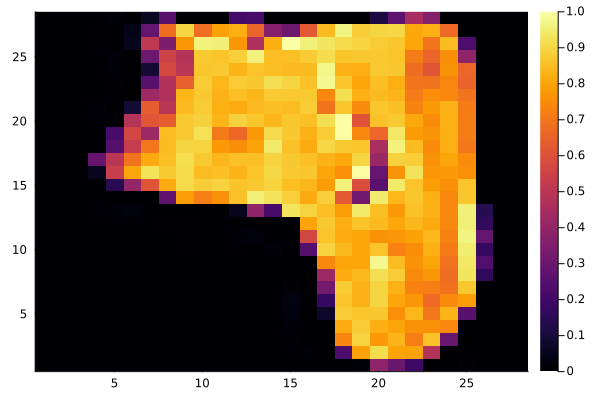

In [15]:
heatmap(x0[:,:,1])

# Test Phasor network

In [16]:
import .PhasorNetworks: default_bias

In [17]:
vsa_layer = 32

32

In [18]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => vsa_layer, soft_angle, init_bias=default_bias),
            Codebook(vsa_layer => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#15),
    layer_4 = WrappedFunction(#16),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 32, use_bias=false),  # 4_096 parameters
        bias = ComplexBias((32,)),                # 64 parameters
    ),
    layer_7 = Codebook(32 => 10),
)         # Total: 106_336 parameters,
          #        plus 320 states.

In [19]:
i_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => vsa_layer, soft_angle, init_bias=default_bias),
            x -> x
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#19),
    layer_4 = WrappedFunction(#20),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 32, use_bias=false),  # 4_096 parameters
        bias = ComplexBias((32,)),                # 64 parameters
    ),
    layer_7 = WrappedFunction(#21),
)         # Total: 106_336 parameters,
          #        plus 0 states.

In [20]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.0056312787 0.04889111 … -0.05050768 0.045184698; -0.040384673 0.033313625 … 0.04332045 -0.045717828; … ; 0.044033002 -0.055932578 … -0.007478507 -0.046164002; 0.024524597 -0.038179252 … 0.0029826495 0.0011508339],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[0.0980228 -0.112927295 … 0.099765204 -0.06487079; -0.023803396 -0.07354423 … -0.04398847 0.122056484; … ; -0.04436694 0.0121455835 … -0.04588809 -0.10667842; 0.14846596 0.01656392 … -0.030736854 -0.014866476],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [21]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.046086155 0.076284826 … 0.099605486 0.10337705; 0.0044109486 -0.043856613 … -0.16627157 0.032334052; … ; 0.1582529 0.1405503 … 0.16080974 0.20941326; 0.06104791 0.057239965 … 0.19613507 0.121493086], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = (codes = Float32[0.73894274 -0.88003933 … 0.108068824 0.19011855; 0.106315136 0.9745741 … -0.52342737 0.42324972; … ; 0.9723028 0.16144669 … 0.5726905 -0.9277966; -0.041530013 -0.32847726 … 0.25916433 -0.333395],)))

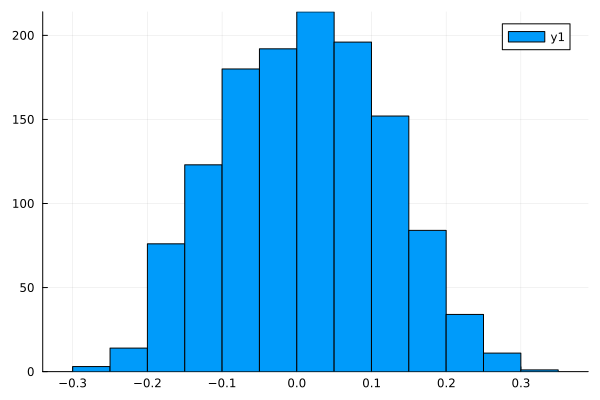

In [22]:
histogram(cdev(vec(yp0)))

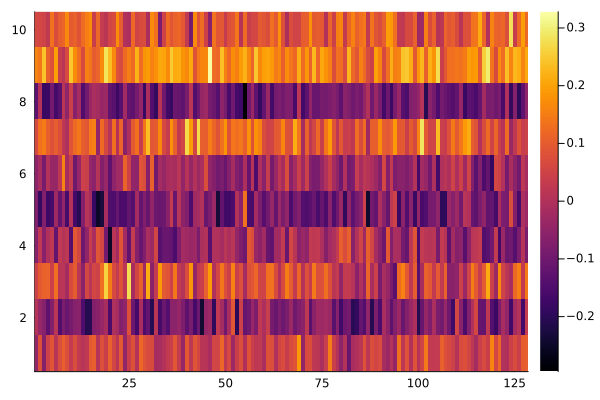

In [23]:
heatmap(cdev(yp0))

In [24]:
size(yp0)

(10, 128)

In [25]:
sh0, st1 = p_model(x0 |> gdev, psp, stp);

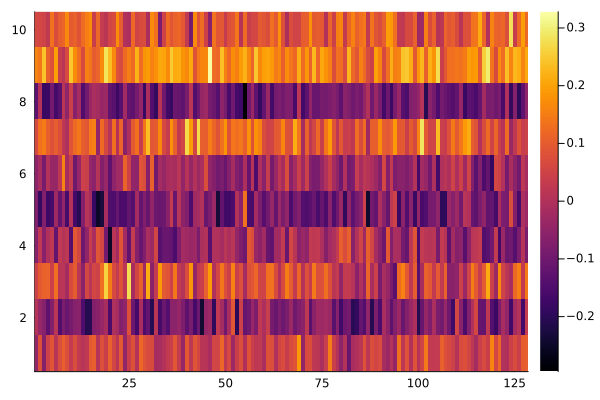

In [26]:
heatmap(cdev(sh0))

In [27]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = evaluate_loss(y_pred, y_onehot, :similarity) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [28]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.9627817264718588

In [29]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

┌ Info: Training on CUDA GPU
└ @ Main.PhasorNetworks /home/wilkie/code/PhasorNetworks.jl/src/network.jl:1263


(Any[0.9627817276597346, 0.8386300172519539, 0.7772979123773371, 0.7407906558145565, 0.6936265893190174, 0.637347760479099, 0.6232573981082956, 0.6047678627598183, 0.6041196491895391, 0.576502410513445  …  0.06908910760547106, 0.055590674468115484, 0.041126596214340394, 0.07293670167861976, 0.06497439571809313, 0.05582220043157657, 0.07897725730452007, 0.07850574822557373, 0.04714264485027752, 0.047680290203524565], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[-0.15994868; 0.058810696; … ; 0.21213476; 0.009093185;;], scale = Float32[1.1392524; 0.9263562; … ; 0.7823267; 0.9652345;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.027739372 0.032275952 … -0.05896136 0.022574417; -0.047770713 0.005657097 … -0.001541345 -0.06440923; … ; 0.025516253 -0.05912704 … -0.0007184266 -0.05090494; -0.016175687 -0.0695711 … -0.025106754 -0.028008275],), bias = (bias_real = Float32[0.9899119, 0.9910037, 1.375255, 1.0247067, 1.1034299, 0.97406965, 1.0350

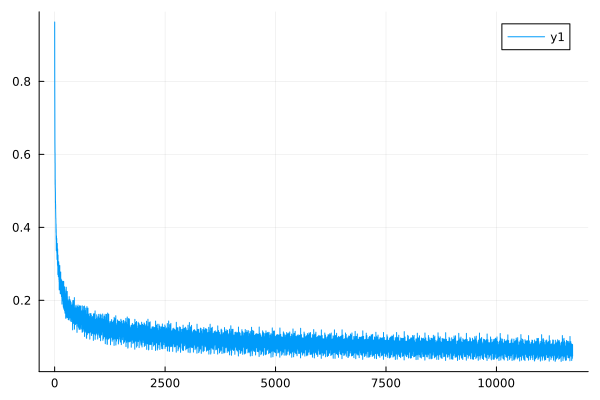

In [30]:
plot(losses_f)

In [31]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[0.1911908 0.96162707 … 0.10029627 0.43563837; -0.04242529 -0.01794571 … -0.10146108 -0.059515; … ; -0.07758163 0.06447659 … 0.048441686 0.09463177; 0.957198 0.17568302 … -0.15360048 0.27411395], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = (codes = Float32[0.73894274 -0.88003933 … 0.108068824 0.19011855; 0.106315136 0.9745741 … -0.52342737 0.42324972; … ; 0.9723028 0.16144669 … 0.5726905 -0.9277966; -0.041530013 -0.32847726 … 0.25916433 -0.333395],)))

In [32]:
size(yp1)

(10, 128)

In [33]:
yp1

10×128 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.191191    0.961627     0.544358    …   0.220208    0.100296    0.435638
 -0.0424253  -0.0179457    0.0911111       0.18662    -0.101461   -0.059515
 -0.316802    0.101196     0.0480746       0.781702    0.0793936  -0.215222
  0.293724    0.056611     0.626251       -0.0560278   0.140148    0.442177
  0.24894    -0.224435    -0.155493       -0.0993992  -0.0283502   0.0543864
  0.0342899  -0.00431912   0.00904259  …  -0.223573    0.189482    0.112618
 -0.214853   -0.0976299    0.132011        0.10762    -0.0850532   0.48238
  0.0114943   0.140741    -0.0152766      -0.0256867   0.935292    0.0939668
 -0.0775816   0.0644766   -0.0637288       0.141863    0.0484417   0.0946318
  0.957198    0.175683     0.313194       -0.146569   -0.1536      0.274114

In [34]:
i0, _ = i_model(x0, ps_train_f |> cdev, st_train_f |> cdev) 

(Float32[0.25871852 0.7895709 … 0.90421313 0.74892217; 0.59621584 0.011345643 … -0.40314427 -0.14986663; … ; 0.99474114 0.90786326 … 0.38576445 0.53052646; -0.24152155 -0.07481344 … 0.36147577 -0.2734902], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = (codes = Float32[0.73894274 -0.88003933 … 0.108068824 0.19011855; 0.106315136 0.9745741 … -0.52342737 0.42324972; … ; 0.9723028 0.16144669 … 0.5726905 -0.9277966; -0.041530013 -0.32847726 … 0.25916433 -0.333395],)))

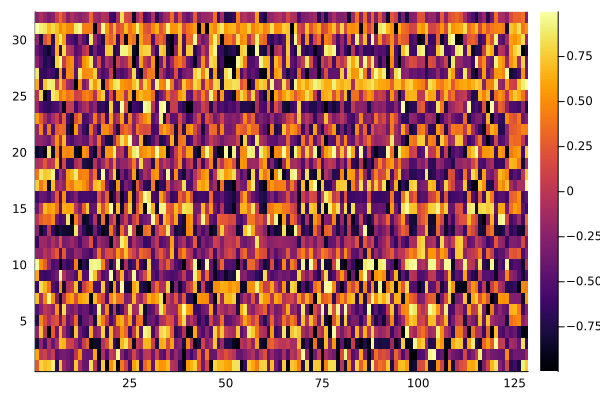

In [35]:
heatmap(i0)

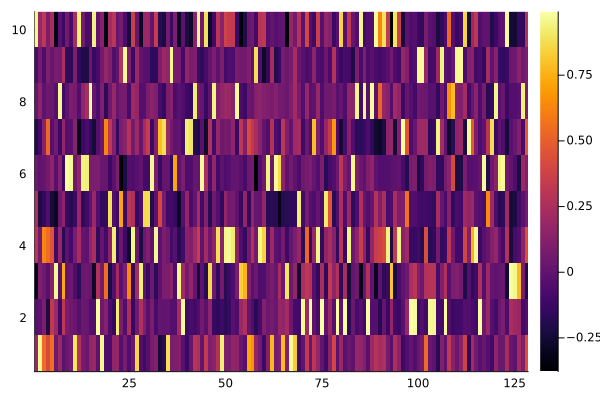

In [36]:
heatmap(cdev(yp1))

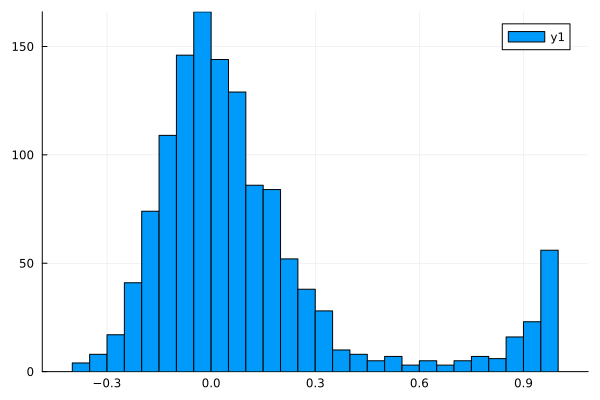

In [37]:
histogram(vec(cdev(yp1)))

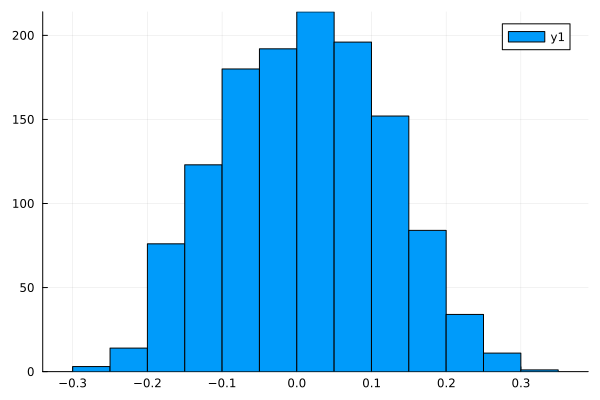

In [38]:
histogram(cdev(vec(yp0)))

In [39]:
x, y = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [40]:
xt, yt = first(test_loader_onehot) .|> gdev;

In [41]:
evaluate_loss(p_model(xt, ps_train_f, st_train_f)[1], onehotbatch(y, 0:9) |> gdev, :similarity)

1×128 CuArray{Float64, 2, CUDA.DeviceMemory}:
 0.0171662  0.00243574  0.000105758  …  0.00128195  0.0228414  0.300579

In [42]:
evaluate_loss(p_model(xt, ps_train_f, st_train_f)[1], onehotbatch(y, 0:9) |> gdev, :similarity) |> mean

0.08501116967622896

In [43]:
evaluate_accuracy(p_model(xt, ps_train_f, st_train_f)[1], onehotbatch(y, 0:9) |> gdev, :similarity) 

([115], 128)

In [44]:
aa =p_model(xt, ps_train_f, st_train_f)[1]

10×128 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.350316    0.0503027   0.0147066   …   0.967761    0.0498688   -0.0404241
 -0.0274065   0.216304    0.990741       -0.0272553  -0.00361832   0.151705
 -0.23159     0.955557    0.233122        0.0510345   0.191278     0.302925
  0.303086   -0.159053   -0.157859        0.0169831  -0.173293    -0.0467943
  0.162766   -0.217287   -0.00548763     -0.162324   -0.158798     0.493117
  0.147912   -0.0117674   0.0435613   …   0.0334781  -0.0456154   -0.26192
 -0.243451    0.112807   -0.0713469       0.0247154   0.0995065    0.512593
  0.185889    0.0187121  -0.0525753       0.0945956   0.0715427   -0.0965695
 -0.116919    0.0282038  -0.0463122       0.0809931   0.863672     0.114839
  0.881871   -0.327159   -0.0278504       0.128122   -0.186337    -0.147702

In [45]:
truth = yt
reduce_dim = 1
reshape_dims = [d == reduce_dim ? 1 : size(truth,d) for d in 1:ndims(truth)]

2-element Vector{Int64}:
   1
 128

In [46]:
getindex.(findall(truth .== 1.0f0), reduce_dim)

128-element CuArray{Int64, 1, CUDA.DeviceMemory}:
 10
  3
  2
  2
  7
  2
  5
  7
  6
  8
  ⋮
  9
  1
  1
 10
 10
  4
  1
  9
  5

In [47]:
predict(yp1, :codebook, reduce_dim=reduce_dim)

128-element Vector{Int64}:
 10
  1
  4
  4
  1
  3
  8
  3
  6
  6
  ⋮
  8
  6
  6
 10
  3
  3
  3
  8
  7

In [48]:
yt

10×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅

In [49]:
loss_and_accuracy(test_loader_onehot, p_model, ps_train_f, st_train_f, args; encoding = :similarity)

(0.09753003339711054, 0.8701)

# Test spiking behavior

In [50]:
import .PhasorNetworks: Codebook, LuxParams

In [51]:
spk_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            Codebook(16 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#27),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = Codebook(16 => 10),
)         # Total: 104_256 parameters,
          #        plus 160 states.

In [52]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.0135705015 -0.05729247 … 0.0163186 -0.017677143; -0.0026602584 0.060192093 … 0.051260214 -0.022274366; … ; -0.023816729 -0.012598705 … 0.053770266 0.045829695; -0.053956818 -0.0069056815 … 0.008795149 -0.054133724],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[-0.14734356 -0.11203233 … -0.10271278 -0.09439357; -0.051993318 -0.111854024 … -0.08929189 0.04747729; … ; -0.074096166 -0.09537681 … 0.05314868 0.041080713; -0.09813437 -0.06701051 … -0.13512348 0.019357903],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [53]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5

In [54]:
ys0 |> size

(2001,)

In [55]:
typeof(ys0)

Vector{CuArray{Float32, 2, DeviceMemory}} (alias for Array{CuArray{Float32, 2, CUDA.DeviceMemory}, 1})

In [56]:
typeof(ys0) <: AbstractVector{<:AbstractArray}

true

In [57]:
ys0s = stack(ys0)

10×128×2001 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  …  -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5     -0.5  -0.5  -0.5  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5

In [58]:
predict(ys0s, :similarity, reduce_dim=1)

128×2001 Matrix{Int64}:
 1  1  1  1  1  1  1  6  1  1  1  4  1  …   4   4   4   4   4   4   4   4   4
 1  1  1  1  1  1  1  6  1  1  1  4  1      1   1   1   1   1   1   1   1   1
 1  1  1  1  1  1  1  6  1  1  1  4  1      1   1   1   1   1   1   1   1   1
 1  1  1  1  1  1  1  6  1  1  1  4  1      1   1   1   1   1   1   1   1   1
 1  1  1  1  1  1  1  6  1  1  1  4  1      1   1   1   1   1   1   1   1   1
 1  1  1  1  1  1  1  6  1  1  1  4  1  …  10  10  10  10  10  10  10  10  10
 1  1  1  1  1  1  1  6  1  1  1  4  1      1   1   1   1   1   1   1   1   1
 1  1  1  1  1  1  1  6  1  1  1  4  1      4   4   4   4   4   4   4   4   4
 1  1  1  1  1  1  1  6  1  1  1  4  1      8   8   8   8   8   8   8   8   8
 1  1  1  1  1  1  1  6  1  1  1  4  1      1   1   1   1   1   1   1   1   1
 ⋮              ⋮              ⋮        ⋱               ⋮                   ⋮
 1  1  1  1  1  1  1  6  1  1  1  4  1      8   8   8   8   8   8   8   8   8
 1  1  1  1  1  1  1  6  1  1  1  4  1  

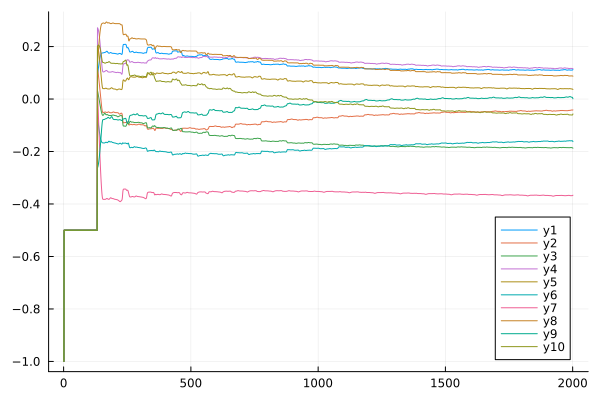

In [59]:
plot(ys0s[:,1,:]' |> cdev)

In [60]:
yp0 |> size

(10, 128)

In [61]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5

In [62]:
y_spk_s = y_spk_f |> stack |> cdev;

In [63]:
size(y_spk_s)

(10, 128, 2001)

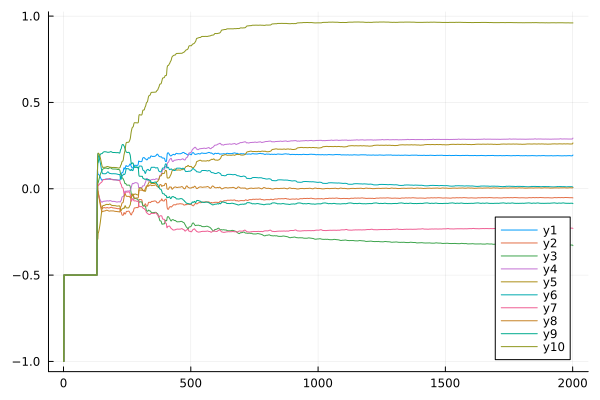

In [64]:
plot(y_spk_s[:,1,:]')

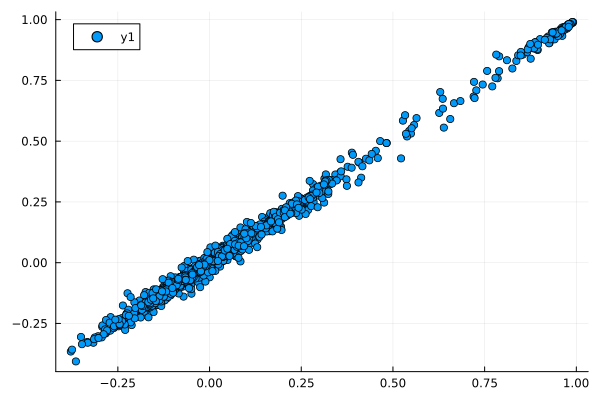

In [65]:
scatter(vec(cdev(yp1)), vec(y_spk_s[:,:,end]))

In [66]:
spk_inner = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            x -> x,
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#29),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = WrappedFunction(#30),
)         # Total: 104_256 parameters,
          #        plus 0 states.

In [67]:
y_spk_i, _ = spk_inner(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(23, 128), CartesianIndex(24, 128), CartesianIndex(25, 128), CartesianIndex(26, 128), CartesianIndex(27, 128), CartesianIndex(28, 128), CartesianIndex(29, 128), CartesianIndex(30, 128), CartesianIndex(31, 128), CartesianIndex(32, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096], Float32[2.0192783, 1.9973667, 1.9985193, 2.0044117, 2.008991, 1.9998486, 2.001809, 2.0098732, 2.0001037, 2.0026813  …  21.472778, 20.526087, 20.50098, 20.576763, 20.501432, 21.00833, 21.423565, 21.498226, 21.408005, 21.006664], (32, 128), 4096, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTup

In [68]:
_, yh0 = first(test_loader_onehot)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 1 0 … 0 0])

In [69]:
lvs = evaluate_loss(y_spk_f, yh0 |> gdev, :similarity)

2001-element Vector{CuArray{Float64, 2, CUDA.DeviceMemory}}:
 [1.999999999999996 1.999999999999996 … 1.999999999999996 1.999999999999996]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 [1.7071068275494765 1.7071068275494765 … 1.7071068275494765 1.7071068275494765]
 ⋮
 [0.0018882308897910896 0.8731528733507814 … 0.8980946704930433 0.951115264604207]
 [0.0018876443413239168 0.872901918188962 … 0.8

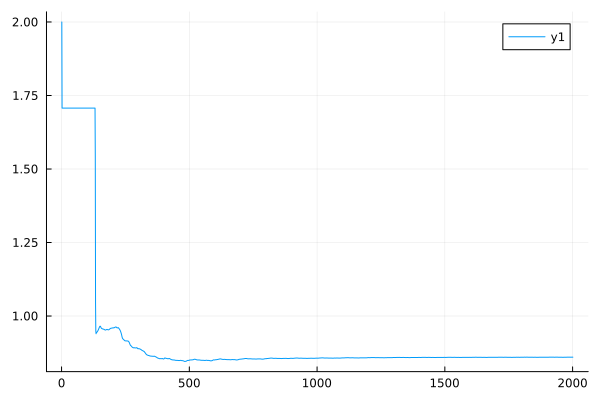

In [70]:
plot(sum.(lvs) ./ 128)

In [71]:
stack(lvs)

1×128×2001 CuArray{Float64, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0

[:, :, 2] =
 1.70711  1.70711  1.70711  1.70711  …  1.70711  1.70711  1.70711  1.70711

[:, :, 3] =
 1.70711  1.70711  1.70711  1.70711  …  1.70711  1.70711  1.70711  1.70711

;;; … 

[:, :, 1999] =
 0.00188502  0.872838  0.818426  1.32472  …  0.692006  0.900002  0.951031

[:, :, 2000] =
 0.00189031  0.872954  0.820141  1.32421  …  0.69105  0.903016  0.952855

[:, :, 2001] =
 0.00190402  0.872343  0.823498  1.32334  …  0.688803  0.909856  0.95653

In [73]:
length(test_loader) * 70 / 60

92.16666666666667

In [74]:
st3 = get_time(y_spk_i.train, (5.0, 10.0))

Spike Train: (32, 128) with 20486 spikes.

In [75]:
st3_b1 = st3[:,1:5]

Spike Train: (32, 5) with 800 spikes.

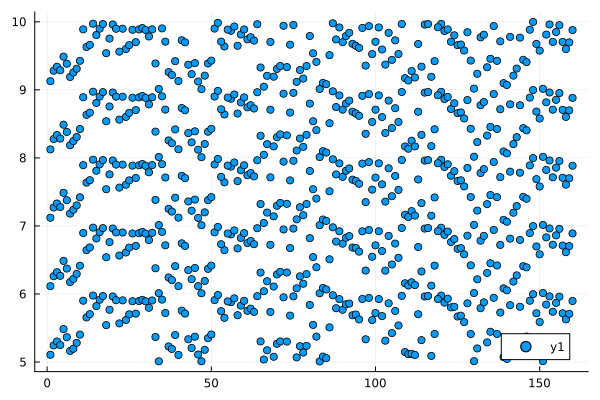

In [76]:
scatter(LinearIndices(st3_b1.shape)[st3_b1.indices], st3_b1.times) 

In [77]:
test_batch = (first(test_loader_onehot),)

((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 1 0 … 0 0]),)

In [78]:
import .PhasorNetworks: spiking_loss_and_accuracy, on_gpu

In [79]:
function spiking_loss_and_accuracy(data_loader, model, ps, st, args; reduce_dim::Int=1, encoding::Symbol = :codebook)
    loss_fn = (x, y) -> evaluate_loss(x, y, encoding, reduce_dim=reduce_dim) .|> cdev

    if args.use_cuda && CUDA.functional()
        dev = gdev
    else
        dev = cdev
    end

    num = 0
    correct = []
    ls = []

    for (x, y) in data_loader
        x = x |> dev
        y = y |> dev
        ŷ, _ = model(x, ps, st)
        loss_vals = sum.(zero_nans.(loss_fn(ŷ, y)))
        append!(ls, [loss_vals,])
        model_correct, answers = cdev.(evaluate_accuracy(ŷ, y, encoding, reduce_dim=reduce_dim))
        append!(correct, model_correct)
        num += answers
    end

    correct = stack(correct) ./ num
    ls = stack(ls) ./ num
    return ls, correct
end

spiking_loss_and_accuracy (generic function with 1 method)

In [80]:
spk_l, spk_a = spiking_loss_and_accuracy(test_batch, spk_model, ps_train_f, st_train_f, args)

([1.9999999999999947; 1.7071068275494756; … ; 0.08257419642025701; 0.08250789508810775;;], [0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375, 0.09375  …  0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625])

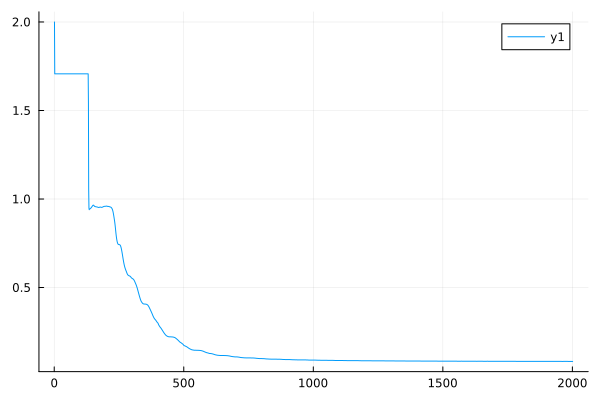

In [81]:
plot(spk_l)

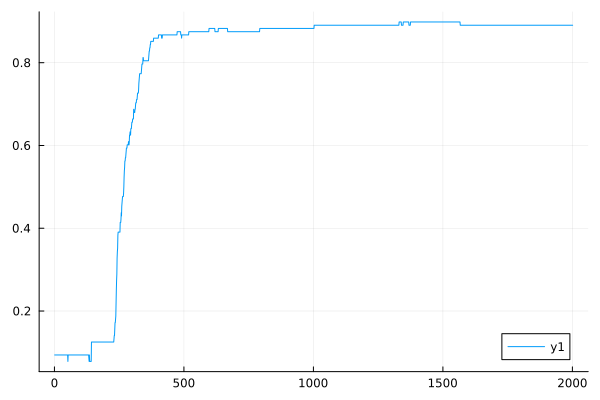

In [82]:
plot(spk_a)

In [84]:
lvs = stack([rand(Float32, 40, 128), rand(Float32, 40, 128)])

40×128×2 Array{Float32, 3}:
[:, :, 1] =
 0.536863   0.0955447  0.988452   0.869449   …  0.109381   0.998647  0.415078
 0.54186    0.57318    0.935181   0.132491      0.308073   0.827472  0.165118
 0.995295   0.140127   0.879556   0.754997      0.137314   0.520403  0.992717
 0.724715   0.556265   0.760881   0.0991462     0.646131   0.678102  0.27769
 0.805813   0.641806   0.966889   0.22612       0.873036   0.905389  0.860212
 0.25936    0.664599   0.959944   0.29031    …  0.668918   0.856939  0.274179
 0.0614292  0.783365   0.620147   0.0714756     0.908078   0.582056  0.761557
 0.996096   0.996615   0.154662   0.0456721     0.0470442  0.685067  0.225691
 0.705634   0.470692   0.461112   0.324717      0.409842   0.431499  0.935461
 0.125265   0.854935   0.457678   0.778314      0.500641   0.631494  0.667797
 ⋮                                           ⋱  ⋮                    
 0.150001   0.538013   0.951252   0.313226      0.132018   0.987149  0.762759
 0.546083   0.589462   0.711288  

# Test conventional network

In [ ]:
construct_model = n -> Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => n, relu),
            Dense(n => 10),
            softmax)

#31 (generic function with 1 method)

In [ ]:
model = construct_model(128)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),            # 100_480 parameters
    layer_4 = Dense(128 => 10),                   # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [ ]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.0112625575 0.09778222 … -0.10101536 0.090369396; -0.080769345 0.06662725 … 0.0866409 -0.091435656; … ; 0.088066004 -0.111865155 … -0.014957014 -0.092328005; 0.049049195 -0.076358505 … 0.005965299 0.0023016678], bias = Float32[0.022867223, -0.005552969, 0.0128062535, 0.016987672, -0.029769417, -0.028511818, -0.034402616, -0.012781019, 0.005802878, 0.033536788  …  0.025755508, 0.0049556494, 0.01800868, -0.015800416, 0.009187677, 0.0042766673, 0.011223478, 0.0118460525, 0.019908717, -0.0135502685]), layer_4 = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327], bias = Float32[-0.031575713, -0.087607525, -0.0455442, 0.051857945, 0.047413476, 0.079458684, 0.08564899, -

In [ ]:
yp, _ = model(x0, ps, st);

In [ ]:
yp |> size

(10, 128)

In [ ]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [ ]:
loss_function(x0, y0, model, ps, st)

2.8641567f0

In [ ]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CPU


(Any[2.8641567f0, 2.5659437f0, 2.387064f0, 2.1986299f0, 2.148335f0, 1.8518924f0, 1.7919455f0, 1.6326872f0, 1.6997683f0, 1.5456713f0  …  0.20519409f0, 0.18482399f0, 0.14162587f0, 0.23544107f0, 0.24074218f0, 0.16624248f0, 0.22450583f0, 0.22559026f0, 0.09765837f0, 0.15866928f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.038406536; 0.017918281; … ; 0.046671223; 0.019242242;;], scale = Float32[0.969162; 0.9840778; … ; 0.9716084; 0.98476076;;]), layer_3 = (weight = Float32[0.0062826984 0.11479646 … -0.08033957 0.10508532; -0.08677065 0.059964977 … 0.0745905 -0.092425995; … ; 0.073537506 -0.12590684 … -0.03909918 -0.11069321; 0.07812478 -0.0465651 … 0.033894457 0.032850184], bias = Float32[0.006977855, 0.0047661057, -0.0036222101, 0.012951335, -0.0019997153, -0.013606623, 0.023555515, 0.011161522, 0.044679105, 0.011207561  …  -0.005677891, -0.011133213, 0.0023209886, 0.019759463, 0.01545383, 0.04544099, 0.01437314, -0.0002253647, 0.03578561, -0.04288651]), layer_4 = (weight = Float

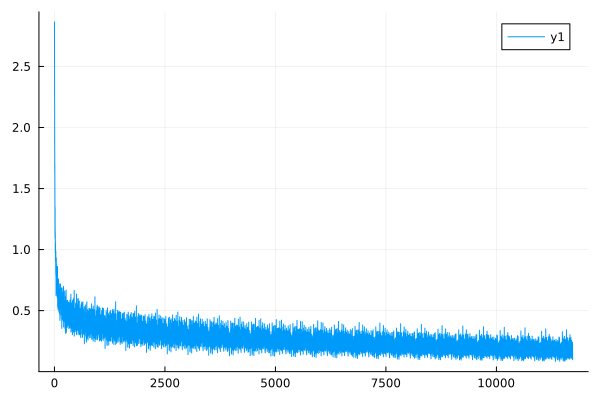

In [ ]:
plot(losses)

In [ ]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [ ]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [ ]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0821

In [ ]:
test(model, test_loader, pst, stt)

0.8824

In [ ]:
function automate_train(n::Integer, e::Integer)
    args = Args(batchsize = 128, epochs = e, use_cuda = true)
    model = construct_model(n)
    ps, st = Lux.setup(args.rng, model)
    losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)
    final_loss = losses[end]
    accuracy = test(model, test_loader, pst, stt)

    return accuracy, final_loss
end

automate_train (generic function with 1 method)

In [ ]:
#automate_train(64, 5)